In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
from calibrate import *

In [2]:
# Path for image storage
impath = '/home/hiram/Documentos/Tesis/Tesis_latex/Imagenes/'

# Check whole data quality

First lets read the whole data.

In [3]:
Temps = pd.read_hdf('calibration/Days14_15.hdf5')

Since the data is way too large for visualizating the whole, we will bin the data in 5 minutes intervals, notice the next cells use a 25 in divition, this is because the data collected in the files of SCI-HI is taken into approximately 12 seconds intervals which means 25 files are generated in a 5 minute interval.

In [4]:
bins = int(np.shape(Temps.values)[1]/25. +1)
T_binned = []
for i in range(bins):
    T_binned.append(Temps.iloc[:,25*i:25*(i+1)].mean(axis=1))
Temps = pd.concat(T_binned, axis=1)

In [5]:
Temps.index = Temps.index.values.round(2)
Temps.columns = 5*np.arange(304)
Temps = Temps[Temps>0.]

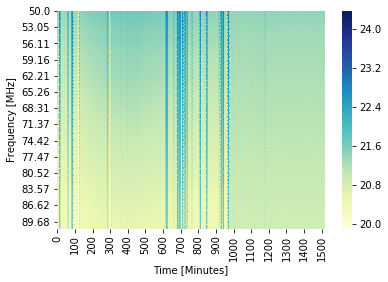

In [6]:
sb.heatmap(np.log10(Temps), cmap='YlGnBu', yticklabels = 400,xticklabels=20)
plt.xlabel('Time [Minutes]')
plt.ylabel('Frequency [MHz]')
#plt.savefig(impath+'Data.png')
plt.show()

The next cells is repeating the same process as above but with the JNC method.

In [7]:
Temps_uncalibrated = pd.read_hdf('calibration/Days14_15_93dBm.hdf5')
Kjnc = pd.read_hdf('calibration/Kjnc_Days14_15_93dBm.hdf5')
Temps_jnc =Kjnc*Temps_uncalibrated

In [8]:
bins = int(np.shape(Temps_jnc.values)[1]/25. +1)
# Data binning in time, 25 is because every 25 data is 5 mins (Aprox 12 secs between data)
T_binned = []
for i in range(bins):
    T_binned.append(Temps_jnc.iloc[:,25*i:25*(i+1)].mean(axis=1))
Temps_jnc = pd.concat(T_binned, axis=1)

Since this data is calibrated already we can filter those temperatures that are negative or outside the desired range, for example in this case we've ignored temperatures above the 100,000 K and below the 100 K. This is done better using base 10 logarithm, this way we just filter those temperatures whose logarithm is above 5 or below 2 are discarded.

In [9]:
Temps_jnc = Temps_jnc[Temps_jnc>0.] # Filter negative temperatures
log_Temps = np.log10(Temps_jnc) 
log_mask = (log_Temps>2.)&(log_Temps<5.)
log_Temps = log_Temps[log_mask]# Filter high and low temperatures 
Temps_jnc = Temps_jnc[log_mask]

In [10]:
log_Temps.index = Temps_jnc.index.values.round(2)
log_Temps.columns = 5*np.arange(304)

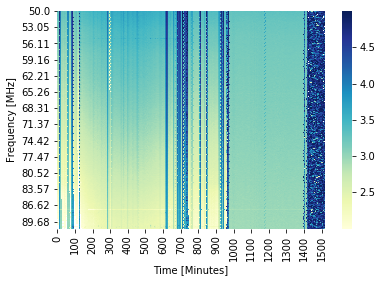

In [11]:
cols = Temps.columns.values
sb.heatmap(log_Temps, cmap='YlGnBu', yticklabels=400, xticklabels=20)
plt.xlabel('Time [Minutes]')
plt.ylabel('Frequency [MHz]')
#plt.savefig(impath+'Data_jnc.png')
plt.show()

# Check data quality

The next cells are a selection of the best looking intervals were the data is more homogenous with no noise in it.

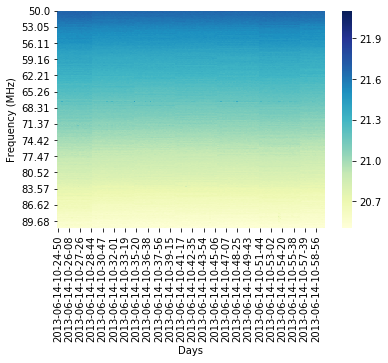

In [12]:
path = 'calibration/Days14_15.hdf5'
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52']
Check_quality(path,dates,savepath = impath)

We will do both calibrations at the same time $\chi^2$ and JNC.

First we will generate the array dates with the desired dates to calibrate and the dates for the theoretical data, note that we've rounded the lower limit of the time by 5 minutes in order to avoid errors.

In [13]:
paths = 'calibration/Days14_15.hdf5' # Data for chi square
paths_jnc = ('calibration/Days14_15_93dBm.hdf5','calibration/Kjnc_Days14_15_93dBm.hdf5') # Data for JNC
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52','2013-06-14 10:30:00.000','2013-06-14 11:00:00.000']

$\chi^2$

In [14]:
#Calibrating the data
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)
Tstd = K_nu*Tstd

In [15]:
#Frequencies of interest
freqs = np.arange(50,91)

Text(0,0.5,u'$K(\\nu)$')

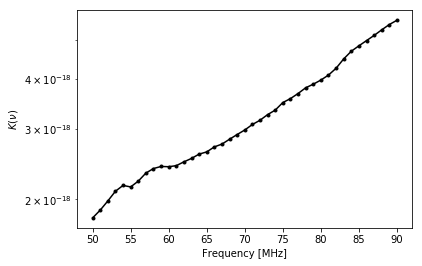

In [16]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_3.png')

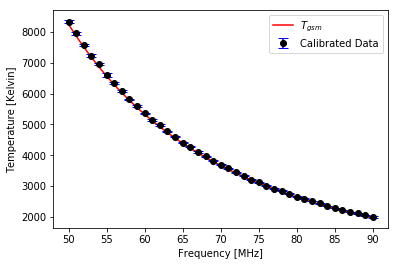

In [17]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_3.png')

Text(0,0.5,u'$K(\\nu)T_{measure}-T_{gsm}$')

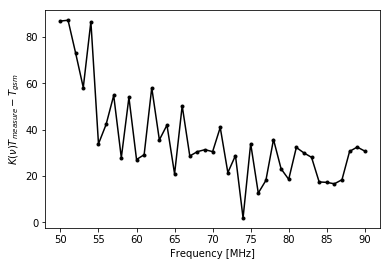

In [18]:
plt.plot(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_3.png')

JNC

In [19]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')
Tstd = K_nu*Tstd

(1.5e-09, 3e-09)

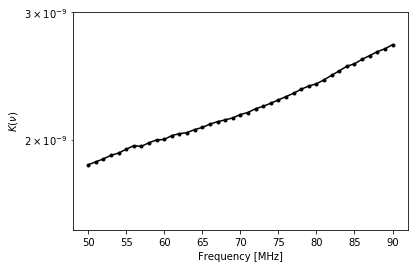

In [20]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.ylim(1.5e-9,3e-9)
#plt.savefig(impath+'K_nu_jnc.png')

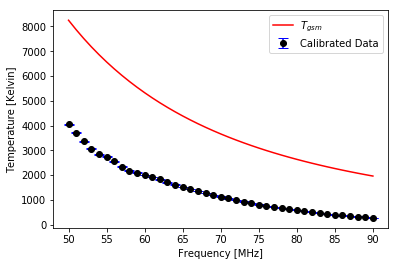

In [21]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_jnc.png')

Text(0,0.5,u'$K(\\nu)T_{measure}-T_{gsm}$')

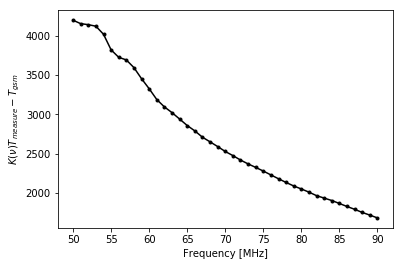

In [22]:
plt.plot(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_jnc.png')

As you can see the JNC method has some problems, we need to discuss about it.

# Dates second try

After this part of the notebook the process is repeated for different dates, so it should be clear what is done.

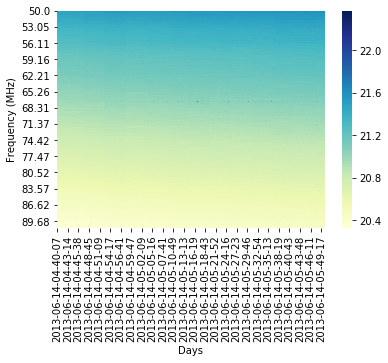

In [23]:
# Quality check
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01']
Check_quality(path,dates,savepath = impath)

In [24]:
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01','2013-06-14 04:45:00.000','2013-06-14 05:50:00.000']

$\chi^2$

In [25]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)
Tstd = K_nu*Tstd

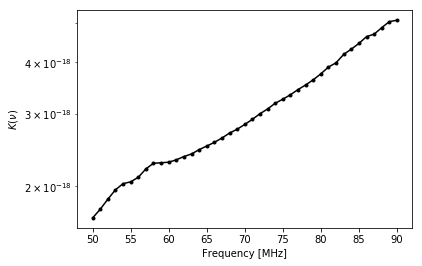

In [26]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_2.png')

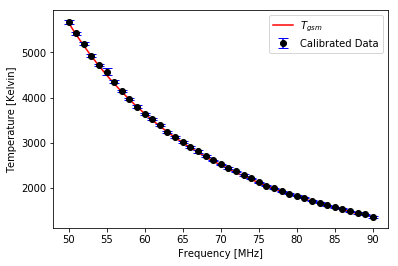

In [27]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_2.png')

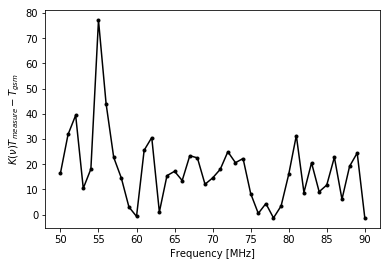

In [28]:
plt.plot(freqs,K_nu*Tmeas - Tgsm,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_2.png')

JNC

In [29]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')
Tstd = K_nu*Tstd

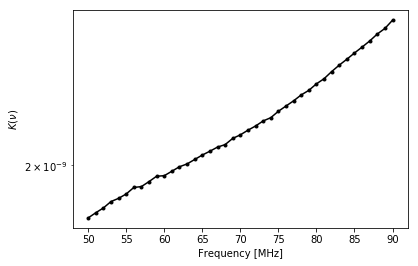

In [30]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_jnc_2.png')

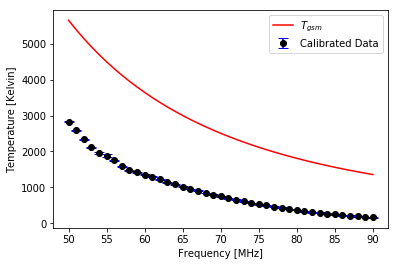

In [31]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_jnc_2.png')

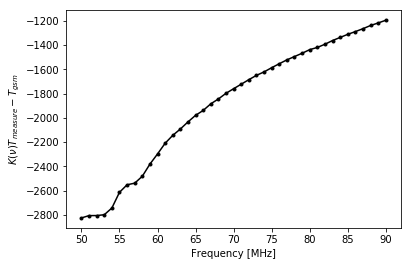

In [32]:
plt.plot(freqs,K_nu*Tmeas - Tgsm,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_jnc_2.png')

# More dates...

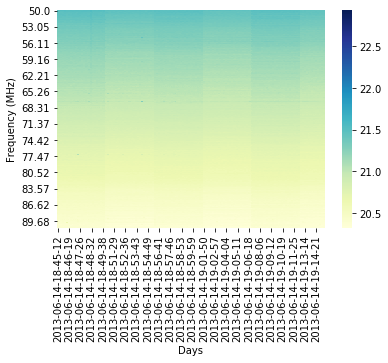

In [33]:
# Quality check
dates = ['2013-06-14-18-45-12','2013-06-14-19-15-05']
Check_quality(path,dates,savepath = impath)

In [34]:
dates = ['2013-06-14-18-45-12','2013-06-14-19-15-05','2013-06-14 18:50:00.000','2013-06-14 19:15:00.000']

$\chi^2$

In [35]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)
Tstd = K_nu*Tstd

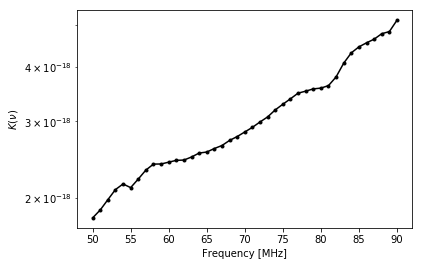

In [36]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_4.png')

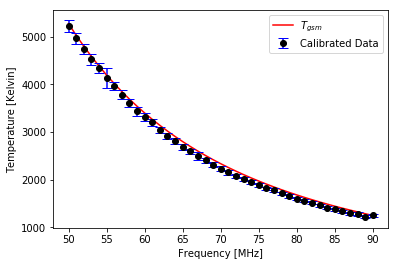

In [37]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_4.png')

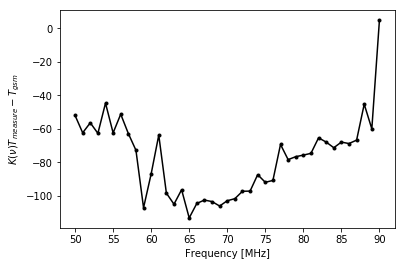

In [38]:
plt.plot(freqs,K_nu*Tmeas - Tgsm,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_4.png')

JNC

In [39]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')
Tstd = K_nu*Tstd

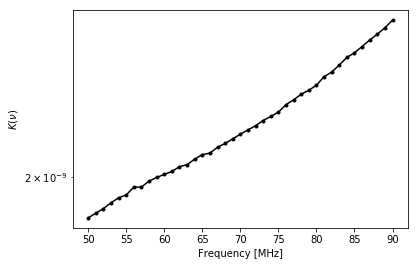

In [40]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_jnc_3.png')

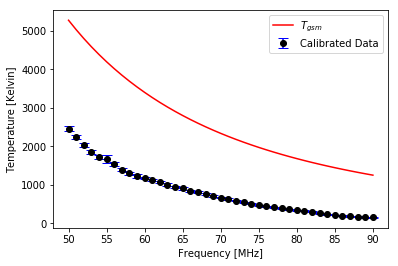

In [41]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_jnc_3.png')

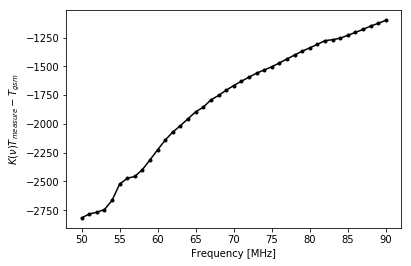

In [42]:
plt.plot(freqs,K_nu*Tmeas - Tgsm,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_jnc_3.png')

# Still don't like it...

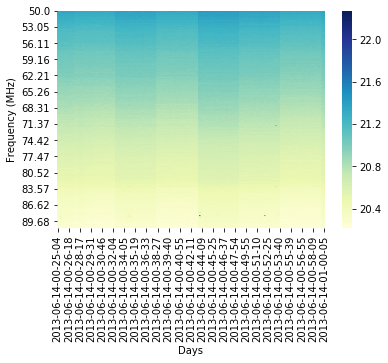

In [43]:
# Quality check
dates = ['2013-06-14-00-25-04','2013-06-14-01-00-06']
Check_quality(path,dates,savepath = impath)

In [44]:
dates = ['2013-06-14-00-25-04','2013-06-14-01-00-06','2013-06-14 00:30:00.000','2013-06-14 01:00:00.000']

$\chi^2$

In [45]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)
Tstd = K_nu*Tstd

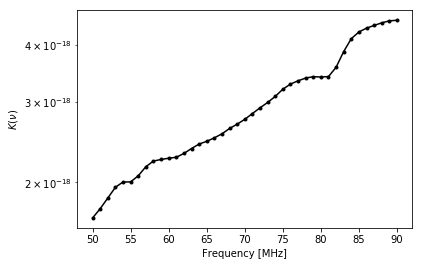

In [46]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_1.png')

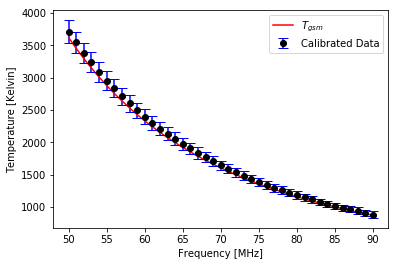

In [47]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_1.png')

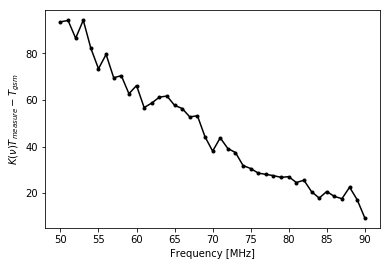

In [48]:
plt.plot(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_1.png')

JNC

In [49]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')
Tstd = K_nu*Tstd

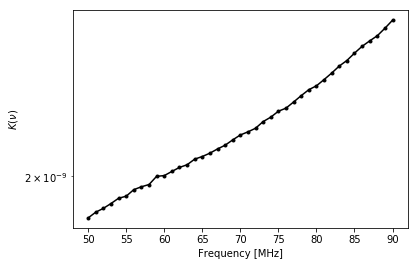

In [50]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
#plt.savefig(impath+'K_nu_jnc_4.png')

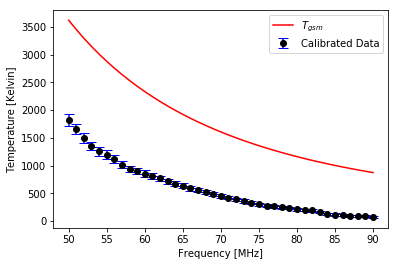

In [51]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.errorbar(freqs,K_nu*Tmeas,yerr=Tstd, color='k',fmt='o',ecolor='b', capsize=5, label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
#plt.savefig(impath+'calibrated_jnc_4.png')

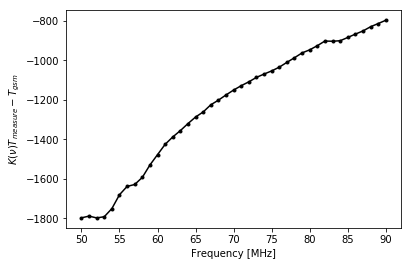

In [52]:
plt.plot(freqs,K_nu*Tmeas - Tgsm,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
#plt.savefig(impath+'KTmeas-Tgsm_jnc_4.png')